## Transfer Learning Inception V3 using Keras

In [32]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Dataset retrived from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Library

In [33]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [34]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train'
valid_path = '/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test'

### Import the Vgg 16 library

In [35]:
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [36]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [37]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train/*')

In [38]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [39]:
prediction = Dense(len(folders), activation='softmax')(x)

#create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [40]:
# Model Summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [41]:
# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 148 images belonging to 2 classes.


In [44]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 40 images belonging to 2 classes.


In [45]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 [==============================] - 12s 2s/step - loss: 3.6882 - accuracy: 0.6360 - val_loss: 1.4533 - val_accuracy: 0.8750
Epoch 2/5
5/5 [==============================] - 7s 1s/step - loss: 3.3131 - accuracy: 0.7074 - val_loss: 0.5505 - val_accuracy: 0.8750
Epoch 3/5
5/5 [==============================] - 7s 1s/step - loss: 2.0475 - accuracy: 0.8515 - val_loss: 0.0569 - val_accuracy: 0.9750
Epoch 4/5
5/5 [==============================] - 7s 2s/step - loss: 0.8318 - accuracy: 0.8690 - val_loss: 0.3100 - val_accuracy: 0.9750
Epoch 5/5
5/5 [==============================] - 7s 1s/step - loss: 0.4316 - accuracy: 0.9130 - val_loss: 0.0041 - val_accuracy: 1.0000


In [46]:
import matplotlib.pyplot as plt

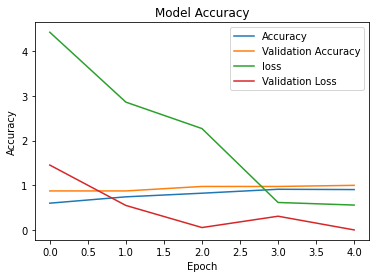

In [47]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [48]:
# save it as a h5 file

from tensorflow.keras.models import load_model
model.save('model_inception.h5')

## Testing

### Example 1

The Image detected is Normal


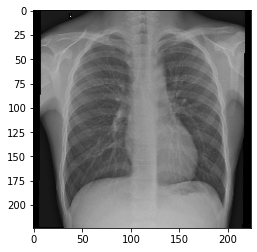

In [51]:
#Example 1

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg', target_size = (224, 224))
imgplot = plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
preds = model.predict(test_image)

preds = np.argmax(preds, axis=1)
if preds==0:
  print("The Image detected is Normal")
elif preds==1:
  print("The Image detected is having Pneumonia ")

### Example 2

The Image detected is having Pneumonia 


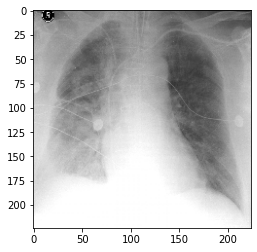

In [52]:
#Example 2

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg', target_size = (224, 224))
imgplot = plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
preds = model.predict(test_image)
preds = np.argmax(preds, axis=1)
if preds==0:
  print("The Image detected is Normal")
elif preds==1:
  print("The Image detected is having Pneumonia ")